# Predicting Grandmasters
## Volume 3 Math 402 Final Project

### Damian and Whitney Anderson,
### Nathan Christiansen, Reagan Howell

#### Date 11/16/2021

# Introduction
Have you ever started playing a game of chess online and wondered if your opponent was one of the top players on lichess.org?

We have ... well, not really, but we were wondering how accurately could you predict your chess opponent based on the moves that they make.
In the past, chess opening moves were studied to find the move order that would give the

So taking the top ~30 players on lichess.org and downloading their classical and rapid format (>25 min and >10 min respectively) games.
With their games in what would it take to help us understand the patterns that these masters are making.

### Importing, Parsing and Cleaning the Data

All games were downloaded from lichess.org open database using links like this

https://lichess.org/api/games/user/Al_shima?rated=true&analysed=true&tags=true&clocks=true&evals=false&opening=false&perfType=rapid

The using regex to remove any of the unimportant information and stripping the .txt files to get the chess game Portable Game Notation (pgn) and the moves that were made.

In [79]:
import os
import regex as re
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV,Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB

from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from statistics import mode

In [73]:
path = './games'
def files(path = './games'):
    """
    Grab all the txt file names and find the player name from it
    Returns the filenames and the players
    """

    file = os.listdir(path)
    players = [file[i][8:-15] for i in range(len(file))]

    return file, players

In [3]:
def get_games(file, player):
    """
    Some of the game files has a chess clock time in the pgn file, so using regex we remove the time stamps.
    We are given the filename and the player name as inputs, then sorting through the file find the color, the variant and the moves played.

    """
    white_clock = re.compile('{ \[%\S* [0-9]*:[0-9]*:[0-9]*\] } [0-9]+\.\.\.')
    black_clock = re.compile('{ \[%\S* [0-9]+:[0-9]+:[0-9]+\] }')
    pre_df = []
    #open the file
    with open(file) as fin:
        lines = fin.readlines()

        for i in range(len(lines)):
            if player in lines[i]:
                color = lines[i][1:6] # get the color that the player is playing

                #Because each game is inconsistent with the rows that are included,
                #we need to check several different rows to find the variant being played.
                if color == "White":
                    if ('Variant' in lines[i+6]):
                        variant = lines[i+6][10:-3]

                    elif ('Variant' in lines[i+7]):
                        variant = lines[i+7][10:-3]

                    elif ('Variant' in lines[i+8]):
                        variant = lines[i+8][10:-3]

                    elif ('Variant' in lines[i + 9]):
                        variant = lines[i + 9][10:-3]

                    elif ('Variant' in lines[i + 10]):
                        variant = lines[i + 10][10:-3]

                    elif ('Variant' in lines[i + 11]):
                        variant = lines[i + 11][10:-3]

                    elif ('Variant' in lines[i + 12]):
                        variant = lines[i + 12][10:-3]

                    #each of these if blocks, tries to find the starting moves, and checks to makes sure
                    #that each game being added to the dataframe is of at least a minimum length
                    if (len(lines[i+14]) > 60) and ('1. ' in lines[i + 14]):
                        line = lines[i + 14]
                        new_line = re.sub(white_clock, str(), line)
                        newer_line = re.sub(black_clock, str(), new_line)
                        pre_df.append([player, color, variant, newer_line])

                    elif (len(lines[i+15]) > 60) and ('1. ' in lines[i + 15]):
                        line = lines[i + 15]
                        new_line = re.sub(white_clock, str(), line)
                        newer_line = re.sub(black_clock, str(), new_line)
                        pre_df.append([player, color, variant, newer_line])

                    elif (len(lines[i+16]) > 60) and ('1. ' in lines[i + 16]):
                        line = lines[i + 16]
                        new_line = re.sub(white_clock, str(), line)
                        newer_line = re.sub(black_clock, str(), new_line)
                        pre_df.append([player, color, variant, newer_line])

                #see comments for the white code
                elif color == "Black":
                    if ('Variant' in lines[i + 6]):
                        variant = lines[i + 6][10:-3]

                    elif ('Variant' in lines[i + 7]):
                        variant = lines[i + 7][10:-3]

                    elif ('Variant' in lines[i + 8]):
                        variant = lines[i + 8][10:-3]

                    elif ('Variant' in lines[i + 9]):
                        variant = lines[i + 9][10:-3]

                    elif ('Variant' in lines[i + 10]):
                        variant = lines[i + 10][10:-3]

                    elif ('Variant' in lines[i + 11]):
                        variant = lines[i + 11][10:-3]

                    elif ('Variant' in lines[i + 12]):
                        variant = lines[i + 12][10:-3]

                    if (len(lines[i+14]) > 60) and ('1. ' in lines[i + 14]):
                        line = lines[i + 14]
                        new_line = re.sub(white_clock, str(), line)
                        newer_line = re.sub(black_clock, str(), new_line)
                        pre_df.append([player, color, variant, newer_line])

                    elif (len(lines[i+15]) > 60) and ('1. ' in lines[i + 15]):
                        line = lines[i + 15]
                        new_line = re.sub(white_clock, str(), line)
                        newer_line = re.sub(black_clock, str(), new_line)
                        pre_df.append([player, color, variant, newer_line])

    return pre_df

In [4]:
def create_database():
    """
    Calls the files, get_games functions to creates a dataframe
    Returns a dataframe

    """
    file, players = files()
    df = []
    for i in range(len(players)):
        #create a list of all the files and their corresponding players and then input that list into the DataFrame
        df.extend(get_games(path + '/' + file[i], players[i]))
    df = pd.DataFrame(df, columns=['Name', 'Color', 'Variant', 'Moves'])
    df = df[df['Variant'] == 'Standard']
    return df

The main function utilizes the create_database() function to access the data files and build our DataFrame. We create a
DataFrame with columns for the players' name, color they were playing as, the variant, and the first 14 moves they make
in their game. We then import that Dataframe into chess_games.csv.

In [5]:
def main():
    """
    After creating the dataframe with the cleaned data, we need to change the one columns of  14 moves into
    14 columns of 1 moves each.
    Then we drop the na that slipped through
    Saves it to a csv file
    Returns None
    """
    df = create_database()
    moves = [f'{i}.' for i in range(1,16)]
    for move in moves:
        df[move] = np.nan
    #instead of having a list of 14 moves, we need columns for each of the individual 14 moves.
    for i in range(len(df)):
        move_order = df.iloc[i].Moves
        if i >830 and i < 835:
            pass
        else:
            # print(i)
            for j in range(len(moves)-1):
                first_ind = move_order.find(moves[j])
                second_ind = move_order.find(moves[j+1])
                if second_ind == -1:
                    break
                else:
                    df.loc[i, moves[j]] = move_order[first_ind:second_ind-1]


    df.drop(df.columns[-1],axis=1,inplace=True)
    df.dropna(inplace=True)
    for i in range(len(moves)-1):
        df.loc[:,moves[i]] = df.loc[:,moves[i]].str[3:]
    df = df.dropna()
    df.to_csv(r'chess_games.csv', index=True, header=True)
    return

main()

### Creating the X-data and the y-targets

Here we load chess_games.csv and break it into the data and the targets. We hope to predict the name of the Grandmaster
playing the game, so we choose the name column as our targets. We are using the first 14 moves the player makes in order
to predict who is playing, so our data is the 14 columns of moves from each game. We create a train/test split of .75
training and .25 testing.

In [83]:
def load_():
    df = pd.read_csv("chess_games.csv")
    targets = df.Name
    data = df.drop(columns=['Name', 'Variant', 'Moves'])
    return data, targets


def sets_(blocklist = []):
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    print(xtrain.columns)
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = sets_()

Index(['Unnamed: 0', 'Color_Black', 'Color_White', '1._Nc3  Nf6 ',
       '1._Nc3  c5 ', '1._Nc3  d5 ', '1._Nc3  d6 ', '1._Nc3  e5 ',
       '1._Nc3  e6 ', '1._Nc3  f5 ',
       ...
       '14._ hxg4  fxg2 ', '14._ hxg4 Bxg4', '14._ hxg4 Nh6',
       '14._ hxg5  Bf5 ', '14._ hxg5  Qxg5+ ', '14._ hxg5  c5 ',
       '14._ hxg5 c5', '14._ hxg6  hxg6 ', '14._ hxg6 f5', '14._ hxg6 hxg6'],
      dtype='object', length=42023)


Now that we have split the data, we use several classifiers with some adjustments to hyper-parameters to figure out
which combination gives us the most accurate prediction of the Grandmaster playing any given game. In order to make
sure that no classifier got a better split than the others, we (begrudgingly) made the xtrain, xtest, ytrain, and ytest 
variables global and accessible to any function or method.


## KNeighborsClassifier
After doing a lot of Grid Searching by "hand", we found this that looking at the 4 nearest neighbors, 
using a distance metric and jst the brute force algorithm resulted in the fastest and highest scoring model type.

In [93]:
def generate_baseline():
    best_guess = mode(ytrain)
    baseline = sum(ytest == best_guess) / len(ytest)
    return baseline, best_guess

For our baseline, we chose to look at the accuracy of always choosing the most common player. We hoped to use the game data to outperform this.

In [107]:
print("Our baseline is {} which we get by guessing {}.".format(*generate_baseline()))

Our baseline is 0.5636363636363636 which we get by guessing Rochade_Augsburg.


In [31]:
def sets_():
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==0],targets[data['Color_White']==0])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

b_xtrain,b_xtest,b_ytrain,b_ytest = sets_()
#black
black_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(b_xtrain,b_ytrain).predict(b_xtest)
black_score = sum(black_predict == b_ytest) / len(b_ytest)

In [30]:
def sets_():
    data, targets = load_()
    # print(data.columns)
    cols = list(data.columns).remove("Color")
    data = pd.get_dummies(data,columns=cols)
    # print(data.columns)
    # print(data[data['Color_White']==1])
    xtrain,xtest,ytrain,ytest = train_test_split(data[data['Color_White']==1],targets[data['Color_White']==1])
    xtrain.drop(columns=['Color_White','Color_Black'],inplace=True)
    xtest.drop(columns=['Color_White','Color_Black'],inplace=True)

    return xtrain,xtest,ytrain,ytest

w_xtrain,w_xtest,w_ytrain,w_ytest = sets_()
#white
white_predict = KNeighborsClassifier(n_neighbors=4,weights='uniform',algorithm='brute').fit(w_xtrain,w_ytrain).predict(w_xtest)
white_score = sum(white_predict == w_ytest) / len(w_ytest)

In [131]:
def confusion_matrix(actual, guesses):
    actual = np.array(actual)
    guesses = np.array(guesses)
    outputs = np.unique(np.concatenate((actual, guesses)))
    output_to_index = dict()
    for i in range(len(outputs)):
        output_to_index[outputs[i]] = i
    
    matrix = np.zeros((len(outputs), len(outputs)))
    
    for i in range(len(actual)):
        matrix[output_to_index[actual[i]], output_to_index[guesses[i]]] += 1
    return outputs, matrix

In [133]:
def summarize_confusion(outputs, matrix):
    for i in range(len(outputs)):
        print(str(outputs[i]) + ":")
        print("Correctly identified " + str(int(matrix[i][i])) + " games out of " + str(int(sum(matrix[i]))) + ".")
        for j in range(len(outputs)):
            if i == j:
                continue
            if matrix[i][j] == 1:
                print(str(int(matrix[i][j])) + " game was misclassified as " + str(outputs[j]) + ".")
            if matrix[i][j] > 1:
                print(str(int(matrix[i][j])) + " games were misclassified as " + str(outputs[j]) + ".")
        print()

In [132]:
black_labels, black_matrix = confusion_matrix(b_ytest, black_predict)
white_labels, white_matrix = confusion_matrix(w_ytest, white_predict)
labels, matrix = confusion_matrix(np.concatenate((w_ytest, b_ytest)), np.concatenate((white_predict, black_predict)))

In [134]:
summarize_confusion(labels, matrix)

ARM__55555:
Correctly identified 10 games out of 10.

Casabianka:
Correctly identified 63 games out of 63.

GabrielTricks2003:
Correctly identified 37 games out of 37.

GrandLapin:
Correctly identified 43 games out of 43.

HoochieChoochieMan:
Correctly identified 21 games out of 22.
1 game was misclassified as GrandLapin.

IAmMateCheckMate:
Correctly identified 65 games out of 66.
1 game was misclassified as HoochieChoochieMan.

Jack202013:
Correctly identified 40 games out of 41.
1 game was misclassified as jbrere.

Jebatdurhaka:
Correctly identified 53 games out of 53.

Konnov_Oleg:
Correctly identified 24 games out of 24.

Leleilre:
Correctly identified 23 games out of 24.
1 game was misclassified as Konnov_Oleg.

Lord-Universe31:
Correctly identified 43 games out of 44.
1 game was misclassified as Leleilre.

Medarde94:
Correctly identified 15 games out of 16.
1 game was misclassified as Lord-Universe31.

Rochade_Augsburg:
Correctly identified 636 games out of 637.
1 game was miscla

The confusion matrix shows which players are misclassified as which other players. The row corresponds to the actual player and the column corresponds to the predicted player. Above each confusion matrix is a list of all the players in the matrix, ordered left to right or top to bottom.

Black
['Casabianka' 'GabrielTricks2003' 'GrandLapin' 'HoochieChoochieMan'
 'IAmMateCheckMate' 'Jebatdurhaka' 'Medarde94' 'Rochade_Augsburg'
 'Squaretaker' 'Thorwald5' 'jbrere' 'kc6' 'splendidkid' 'xx-bob']


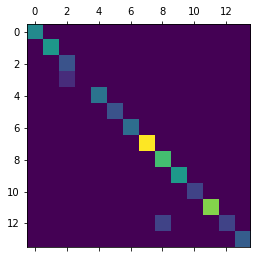

White
['ARM__55555' 'Casabianka' 'GabrielTricks2003' 'GrandLapin'
 'HoochieChoochieMan' 'IAmMateCheckMate' 'Jack202013' 'Jebatdurhaka'
 'Konnov_Oleg' 'Leleilre' 'Lord-Universe31' 'Medarde94' 'Rochade_Augsburg'
 'RusChessCoach' 'SouthernChessPlayer' 'Squaretaker' 'Suleymanov_Marat'
 'Thorwald5' 'jbrere' 'kc6' 'nmiq' 'splendidkid' 'xx-bob']


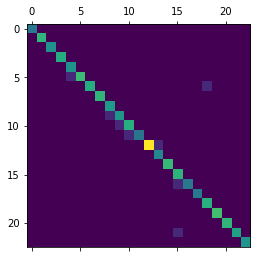

Combined
['ARM__55555' 'Casabianka' 'GabrielTricks2003' 'GrandLapin'
 'HoochieChoochieMan' 'IAmMateCheckMate' 'Jack202013' 'Jebatdurhaka'
 'Konnov_Oleg' 'Leleilre' 'Lord-Universe31' 'Medarde94' 'Rochade_Augsburg'
 'RusChessCoach' 'SouthernChessPlayer' 'Squaretaker' 'Suleymanov_Marat'
 'Thorwald5' 'jbrere' 'kc6' 'nmiq' 'splendidkid' 'xx-bob']


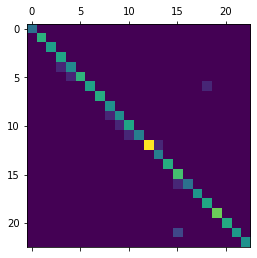

In [139]:
print("Black")
print(black_labels)
plt.matshow(np.log(black_matrix + 1))
plt.show()
print("White")
print(white_labels)
plt.matshow(np.log(white_matrix + 1))
plt.show()
print("Combined")
print(labels)
plt.matshow(np.log(matrix + 1))
plt.show()

In [47]:
score = (white_score * len(w_ytest) + black_score * len(b_ytest)) / (len(b_ytest) + len(w_ytest))
print("White classification", white_score)
print("Black classification", black_score)
print("Average score", score)

White classification 0.9930555555555556
Black classification 0.9931818181818182
Average score 0.9930904522613065


In [12]:
KNeighborsClassifier(n_neighbors=4,weights='distance',algorithm='brute').fit(xtrain,ytrain).score(xtest,ytest)

0.6574481458202388

## MultinomialNB

In [9]:
MultinomialNB().fit(xtrain,ytrain).score(xtest,ytest)


0.6228786926461345

## Random Forests

In [10]:
RandomForestClassifier().fit(xtrain,ytrain).score(xtest,ytest)


0.6209930861093652

## MLPClassifier

In [13]:
MLPClassifier(hidden_layer_sizes=(50,)).fit(xtrain,ytrain).score(xtest,ytest)

0.6323067253299811